# Neural Network Specifics:
- We're defining a feed-forawrd NN with four layers (input layer, two hidden layers, and output layer).
- Input layer is each of the 784 grayscale values
- The hidden layers will have sixteen neurons each.
- Activation functions of hidden layer neurons will be the ReLU
- There will be 10 output layer neurons, representing the computed probability of the digit the input image represents.
- Activation functions of the output layer will be softmax
- We'll use cross entropy as the loss function

Import packages

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load Dataset

In [136]:
dataset_train = pd.read_csv("mnist_train.csv").to_numpy()
dataset_test = pd.read_csv("mnist_test.csv").to_numpy()

Initialise weight matrices and bias vectors using random normal distrubution

In [121]:
class Layer:
    z=0
    a=0
    def __init__(self, dimensions):
        self.weights=np.random.normal(loc=0,scale=0.01,size=dimensions)
        self.biases=np.random.normal(loc=0, scale=0.01, size=dimensions[1])

#Layer 1
l1=Layer((784,16))

#Layer 2
l2=Layer((16,16))

#Layer 3
l3=Layer((16,10))

Define Activation functions

In [122]:
def ReLU(x):
    return np.maximum(x,0)

def softmax(x):
    m=np.max(x)
    return np.exp(x-m)/np.exp(x-m).sum()

Implement Forward Propagation

In [123]:
def forward_prop(training_data):
    l1.z=np.dot(training_data[1:],l1.weights)+l1.biases
    l1.a=ReLU(l1.z)

    l2.z=np.dot(l1.z, l2.weights)+l2.biases
    l2.a=ReLU(l2.z)

    l3.z=np.dot(l2.z, l3.weights)+l3.biases
    l3.a=softmax(l3.z)
    return l1, l2, l3

One-hot encoding

In [124]:
def one_hot(training_data):
    y=np.zeros(10)
    index=training_data[0]
    y[index]=1
    return y

Implement cross-entropy loss


In [125]:
def ce_loss(training_data, predictions):
    epsilon = 1e-10
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    y=one_hot(training_data)
    ce= -np.mean(np.log(predictions)*y)
    return ce

Define backpropagation

In [126]:
def dReLU(z):
    return z>0

def backword_prop(training_data, l1,l2,l3,y):
    dZ3=l3.a-y
    dZ2=np.dot(l3.weights, l3.a-y) * dReLU(l2.z)
    dZ1=np.dot(l2.weights, dZ2) * dReLU(l1.z)
    dW3 = np.outer(l2.a, dZ3)
    dW2 = np.outer(l1.a, dZ2)
    dW1 = np.outer(training_data[1:], dZ1)
    dB1 = dZ1
    dB2=dZ2
    dB3= dZ3

    return dW1, dW2, dW3, dB1, dB2, dB3


Save and load model

In [127]:
def save_model():
    np.savez("trained_parameters.npz", l1_weights=l1.weights, l1_biases=l1.biases,
         l2_weights=l2.weights, l2_biases=l2.biases,
         l3_weights=l3.weights, l3_biases=l3.biases)

In [128]:
def load_model():
    npzfile = np.load("trained_parameters.npz")
    l1.weights=npzfile["l1_weights"]
    l1.biases=npzfile["l1_biases"]
    l2.weights=npzfile["l2_weights"]
    l2.biases=npzfile["l2_biases"]
    l3.weights=npzfile["l3_weights"]
    l3.biases=npzfile["l3_biases"]

Training

In [129]:
learning_rate=0.0003
epochs = 16384
batch_size = 64
min_loss = np.inf
np.random.shuffle(dataset_train)

for epoch in range(epochs):
    gradient = {"dW1": np.zeros(l1.weights.shape), 
                "dB1": np.zeros(l1.biases.shape),
                "dW2": np.zeros(l2.weights.shape), 
                "dB2": np.zeros(l2.biases.shape), 
                "dW3": np.zeros(l3.weights.shape), 
                "dB3": np.zeros(l3.biases.shape)}
    loss=0
    batch_start = epoch*batch_size % dataset_train.shape[0]
    try:
        batch = dataset_train[batch_start:batch_start+batch_size]
    except IndexError:
        batch = dataset_train[batch_start:]
    np.random.shuffle(batch)
    for training_data in batch:
        l1,l2,l3=forward_prop(training_data)
        y=one_hot(training_data)
        dW1, dW2, dW3, dB1, dB2, dB3=backword_prop(training_data, l1,l2,l3,y)

        gradient["dW1"]=np.add(gradient["dW1"],dW1)
        gradient["dW2"]=np.add(gradient["dW2"],dW2)
        gradient["dW3"]=np.add(gradient["dW3"],dW3)

        gradient["dB1"]=np.add(gradient["dB1"],dB1)
        gradient["dB2"]=np.add(gradient["dB2"],dB2)
        gradient["dB3"]=np.add(gradient["dB3"],dB3)

        loss+=ce_loss(training_data, l3.a)

    for array in gradient.values():
        array/=batch_size
    
    if loss<min_loss:
        print(f"Epoch: {epoch}, Min Loss: {min_loss}")
        min_loss=loss
        save_model()

    l1.weights -= learning_rate * gradient["dW1"]
    l1.biases -= learning_rate * gradient["dB1"]
    l2.weights -= learning_rate * gradient["dW2"]
    l2.biases -= learning_rate * gradient["dB2"]
    l3.weights -= learning_rate * gradient["dW3"]
    l3.biases -= learning_rate * gradient["dB3"]

Epoch: 0, Min Loss: inf
Epoch: 1, Min Loss: 14.777260109874872
Epoch: 2, Min Loss: 14.718259947673001
Epoch: 4, Min Loss: 14.710172633271549
Epoch: 6, Min Loss: 14.709166293537574
Epoch: 9, Min Loss: 14.693582538792525
Epoch: 12, Min Loss: 14.688234398097643
Epoch: 18, Min Loss: 14.671447100384405
Epoch: 49, Min Loss: 14.657377932580076
Epoch: 51, Min Loss: 14.6550434218001
Epoch: 102, Min Loss: 14.595608542228307
Epoch: 142, Min Loss: 14.589379463428658
Epoch: 144, Min Loss: 14.587317446227647
Epoch: 154, Min Loss: 14.571635282708773
Epoch: 182, Min Loss: 14.53842071113753
Epoch: 218, Min Loss: 14.500125987622825
Epoch: 225, Min Loss: 14.496028495775349
Epoch: 258, Min Loss: 14.454245322793923
Epoch: 287, Min Loss: 14.424639281034732
Epoch: 310, Min Loss: 14.354228319060883
Epoch: 329, Min Loss: 14.346813858714167
Epoch: 336, Min Loss: 14.337091725402432
Epoch: 361, Min Loss: 14.27863488515498
Epoch: 377, Min Loss: 14.259436541395567
Epoch: 388, Min Loss: 14.252673914037372
Epoch: 397

Run custom tests:

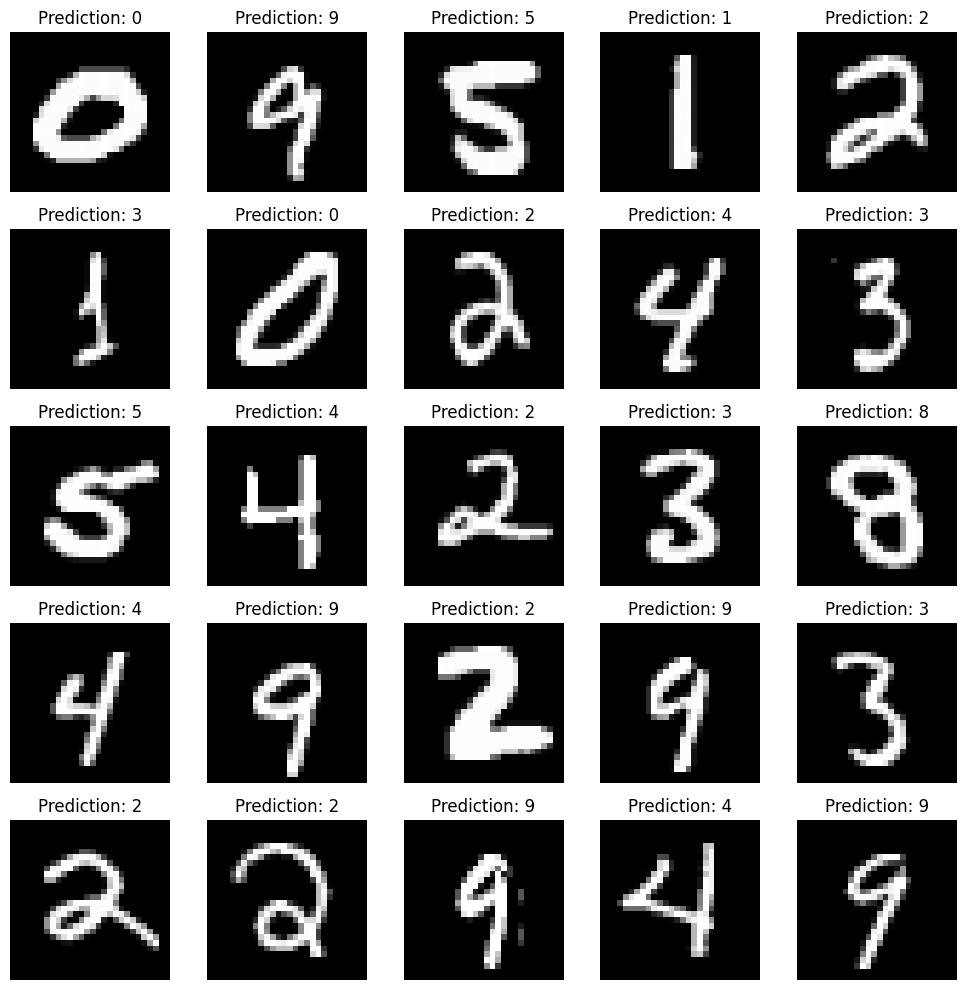

In [135]:
load_model()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    index = np.random.randint(0, dataset_test.shape[0])
    image = dataset_test[index][1:].reshape(28, 28)
    ax.imshow(image, cmap="gray")
    ax.axis('off')
    l1, l2, l3 = forward_prop(dataset_test[index])
    prediction = np.argmax(l3.a)
    ax.set_title(f"Prediction: {prediction}")

plt.tight_layout()

plt.show()


Determine success rate

In [139]:
sucesses=0
for test_data in dataset_test:
    l1,l2,l3 = forward_prop(test_data)
    if np.argmax(l3.a)==test_data[0]:
        sucesses+=1
print(f"Accuracy: {sucesses/dataset_test.shape[0]*100}%")

Accuracy: 90.41%
